# Journal Data Analysis and Visualization

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

# Set visualization style
sns.set_theme()  # This sets the seaborn theme
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Display all columns
pd.set_option('display.max_columns', None)

In [8]:
# Load the dataset
df = pd.read_csv('../Data/journal_synthetic.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1200, 15)


,Region,City,County,Entity,District,Gross,Taxable,InputSource,PlaceDetermination,EntryId,Id,LogId,TaxRate,Year,Month
0,US-GA,Atlanta,Fulton,Reliance,District-68,7250.30,843.21,balanceimport,taxareacode,100000,J100000,L100000,0.1163,2024,2
1,US-NY,Manhattan,New York,DeMart,District-27,3522.39,278.62,balanceimport,taxareacode,100001,J100001,L100001,0.0791,2023,11
2,US-MI,Pontiac,Oakland,DeMart,District-23,4673.86,415.51,balanceimport,taxareacode,100002,J100002,L100002,0.0889,2023,11
3,US-GA,Lawrenceville,Gwinnett,DeMart,District-97,279.29,28.49,balanceimport,taxareacode,100003,J100003,L100003,0.1020,2024,12
4,US-FL,Hialeah,Miami-Dade,Reliance,District-92,3806.91,301.51,balanceimport,taxareacode,100004,J100004,L100004,0.0792,2023,9


## 1. Outlier Detection

In [9]:
# Function to detect outliers using Z-score method
def detect_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs(stats.zscore(df[column]))
    outliers = df[z_scores > threshold]
    return outliers, len(outliers)

# Function to detect outliers using IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, len(outliers)

# Detect outliers in numerical columns
numerical_cols = ['Gross', 'Taxable', 'TaxRate']

for col in numerical_cols:
    print(f"\nOutlier Analysis for {col}:")
    
    # Z-score method
    outliers_z, count_z = detect_outliers_zscore(df, col)
    print(f"Z-score method: {count_z} outliers detected ({count_z/len(df)*100:.2f}%)")
    
    # IQR method
    outliers_iqr, count_iqr = detect_outliers_iqr(df, col)
    print(f"IQR method: {count_iqr} outliers detected ({count_iqr/len(df)*100:.2f}%)")


Outlier Analysis for Gross:
Z-score method: 25 outliers detected (2.08%)
IQR method: 37 outliers detected (3.08%)

Outlier Analysis for Taxable:
Z-score method: 18 outliers detected (1.50%)
IQR method: 43 outliers detected (3.58%)

Outlier Analysis for TaxRate:
Z-score method: 0 outliers detected (0.00%)
IQR method: 0 outliers detected (0.00%)


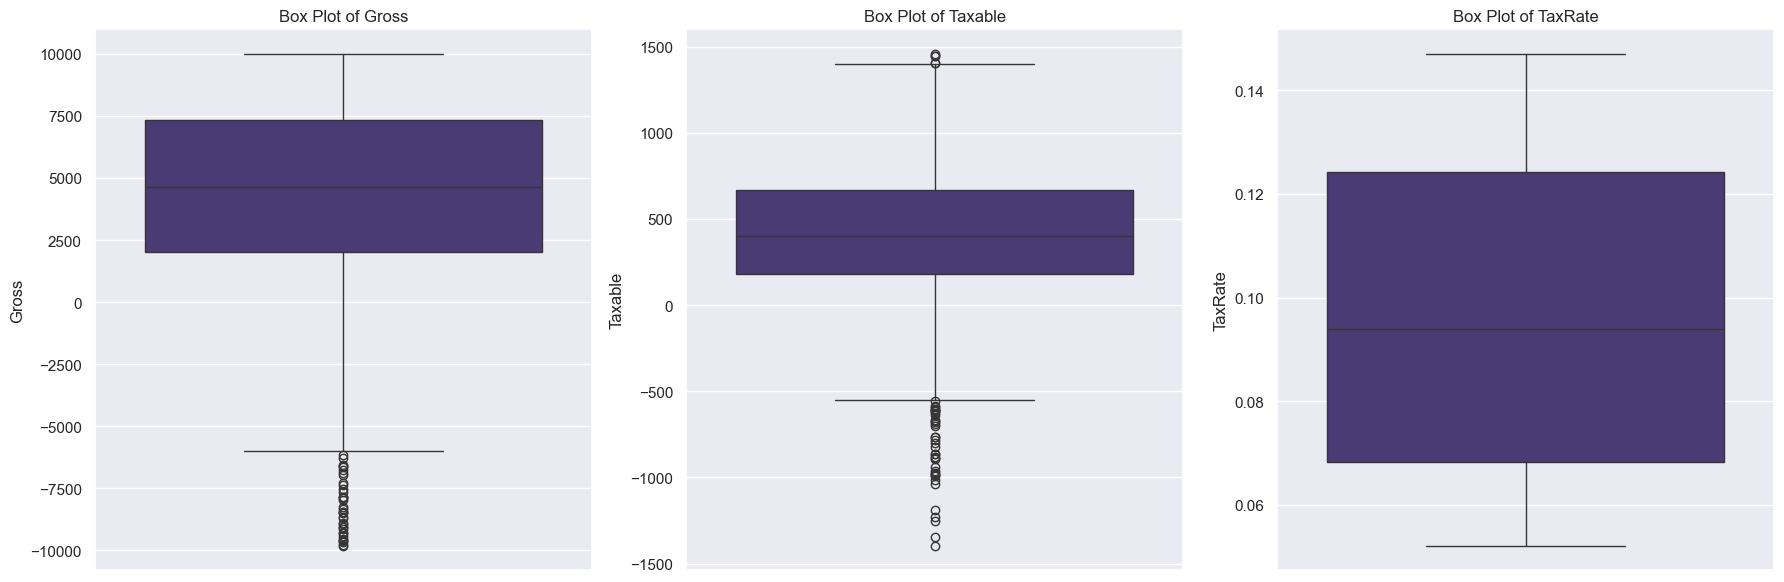

In [10]:
# Visualize outliers using box plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

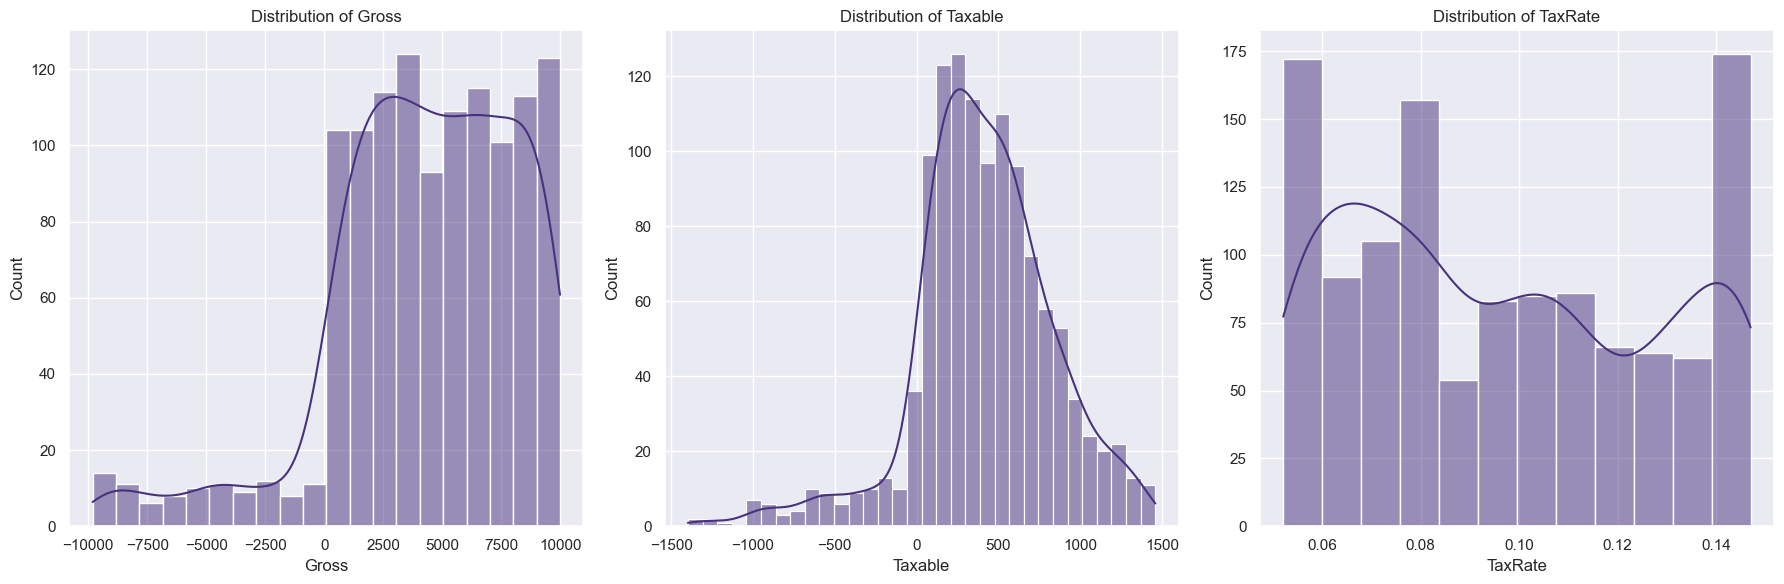

In [11]:
# Visualize the distribution of numerical columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

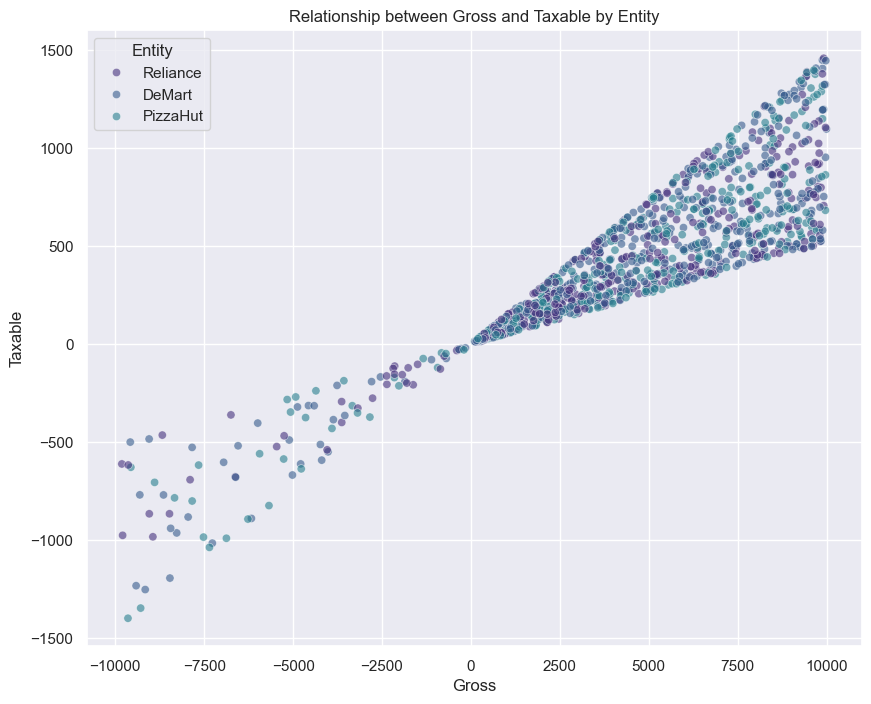

In [12]:
# Scatter plot to visualize relationship between Gross and Taxable
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Gross', y='Taxable', data=df, alpha=0.6, hue='Entity')
plt.title('Relationship between Gross and Taxable by Entity')
plt.xlabel('Gross')
plt.ylabel('Taxable')
plt.show()

## 2. Feature Engineering

In [13]:
# Create a copy of the dataframe for preprocessing
df_processed = df.copy()

# Create new features
# 1. Tax Amount (Taxable * TaxRate)
df_processed['TaxAmount'] = df_processed['Taxable'] * df_processed['TaxRate']

# 2. Profit Margin ((Gross - Taxable) / Gross)
df_processed['ProfitMargin'] = (df_processed['Gross'] - df_processed['Taxable']) / df_processed['Gross']

# 3. Create a Date column from Year and Month
df_processed['Date'] = pd.to_datetime(df_processed['Year'].astype(str) + '-' + df_processed['Month'].astype(str) + '-01')
df_processed['Quarter'] = df_processed['Date'].dt.quarter

# 4. Tax Efficiency (TaxAmount / Gross)
df_processed['TaxEfficiency'] = df_processed['TaxAmount'] / df_processed['Gross']

# Display the new features
df_processed[['Gross', 'Taxable', 'TaxRate', 'TaxAmount', 'ProfitMargin', 'Date', 'Quarter', 'TaxEfficiency']].head()

,Gross,Taxable,TaxRate,TaxAmount,ProfitMargin,Date,Quarter,TaxEfficiency
0,7250.30,843.21,0.1163,98.065323,0.883700,2024-02-01,1,0.013526
1,3522.39,278.62,0.0791,22.038842,0.920900,2023-11-01,4,0.006257
2,4673.86,415.51,0.0889,36.938839,0.911099,2023-11-01,4,0.007903
3,279.29,28.49,0.1020,2.905980,0.897991,2024-12-01,4,0.010405
4,3806.91,301.51,0.0792,23.879592,0.920799,2023-09-01,3,0.006273


## 3. Correlation Analysis

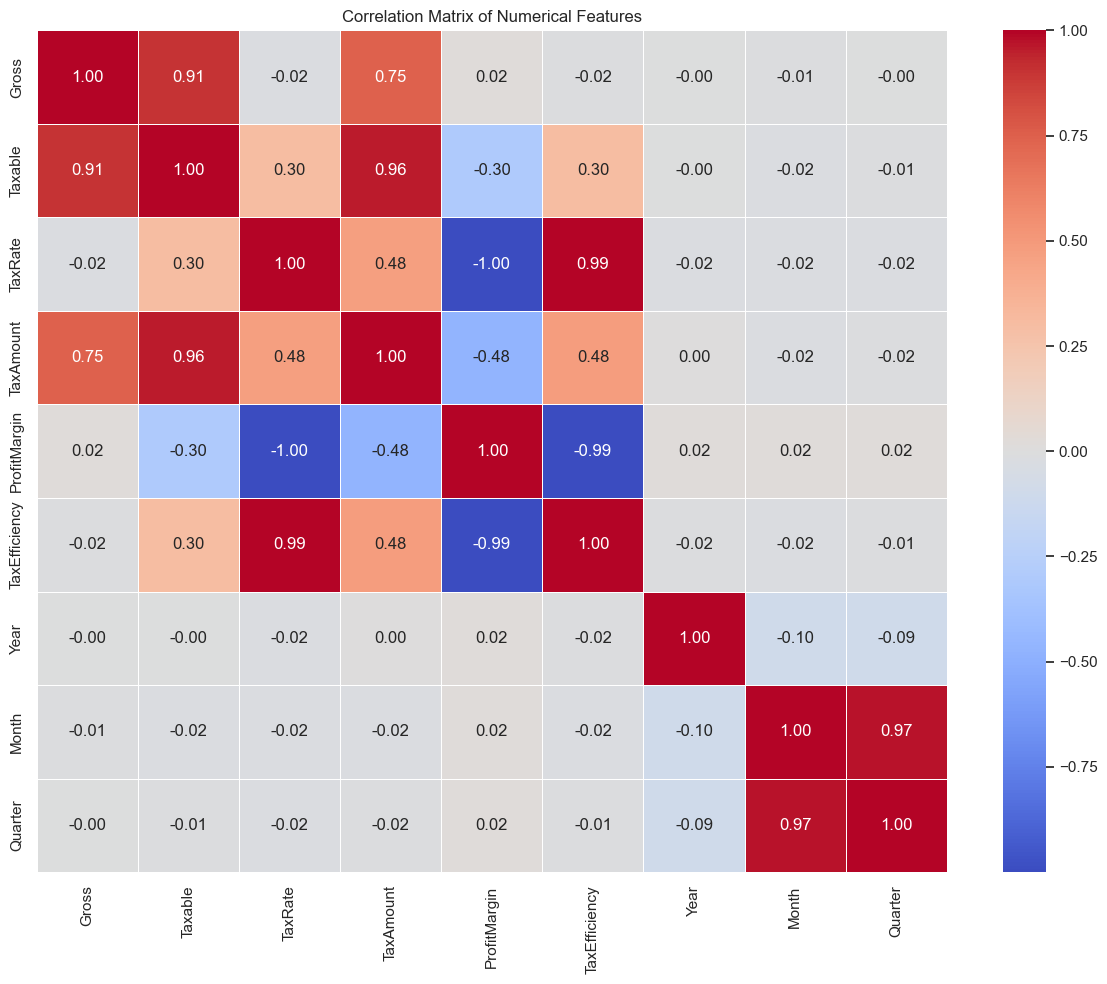

In [14]:
# Select numerical columns for correlation analysis
numerical_cols_extended = ['Gross', 'Taxable', 'TaxRate', 'TaxAmount', 'ProfitMargin', 
                          'TaxEfficiency', 'Year', 'Month', 'Quarter']

# Calculate correlation matrix
correlation_matrix = df_processed[numerical_cols_extended].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

## 4. Feature Dependency Analysis

In [15]:
# Encode categorical variables
high_cardinality_cols = ['City', 'County', 'District']

for col in high_cardinality_cols:
    le = LabelEncoder()
    df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col])

# Feature importance using Random Forest
X = df_processed[['Year', 'Month', 'Quarter', 'City_encoded', 'County_encoded', 'District_encoded']]
y_gross = df_processed['Gross']
y_taxable = df_processed['Taxable']
y_taxrate = df_processed['TaxRate']

# Train Random Forest for Gross
rf_gross = RandomForestRegressor(n_estimators=100, random_state=42)
rf_gross.fit(X, y_gross)

# Get feature importances for Gross
feature_importance_gross = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_gross.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance for Gross:")
print(feature_importance_gross)

Feature Importance for Gross:
            Feature  Importance
5  District_encoded    0.305777
3      City_encoded    0.258805
4    County_encoded    0.190270
1             Month    0.139235
0              Year    0.069270
2           Quarter    0.036643


In [16]:
# Train Random Forest for Taxable
rf_taxable = RandomForestRegressor(n_estimators=100, random_state=42)
rf_taxable.fit(X, y_taxable)

# Get feature importances for Taxable
feature_importance_taxable = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_taxable.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance for Taxable:")
print(feature_importance_taxable)

Feature Importance for Taxable:
            Feature  Importance
5  District_encoded    0.295307
3      City_encoded    0.278632
4    County_encoded    0.177228
1             Month    0.141043
0              Year    0.070388
2           Quarter    0.037402


In [17]:
# Train Random Forest for TaxRate
rf_taxrate = RandomForestRegressor(n_estimators=100, random_state=42)
rf_taxrate.fit(X, y_taxrate)

# Get feature importances for TaxRate
feature_importance_taxrate = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_taxrate.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance for TaxRate:")
print(feature_importance_taxrate)

Feature Importance for TaxRate:
            Feature  Importance
3      City_encoded    0.767915
4    County_encoded    0.226245
5  District_encoded    0.003028
1             Month    0.001950
0              Year    0.000445
2           Quarter    0.000417


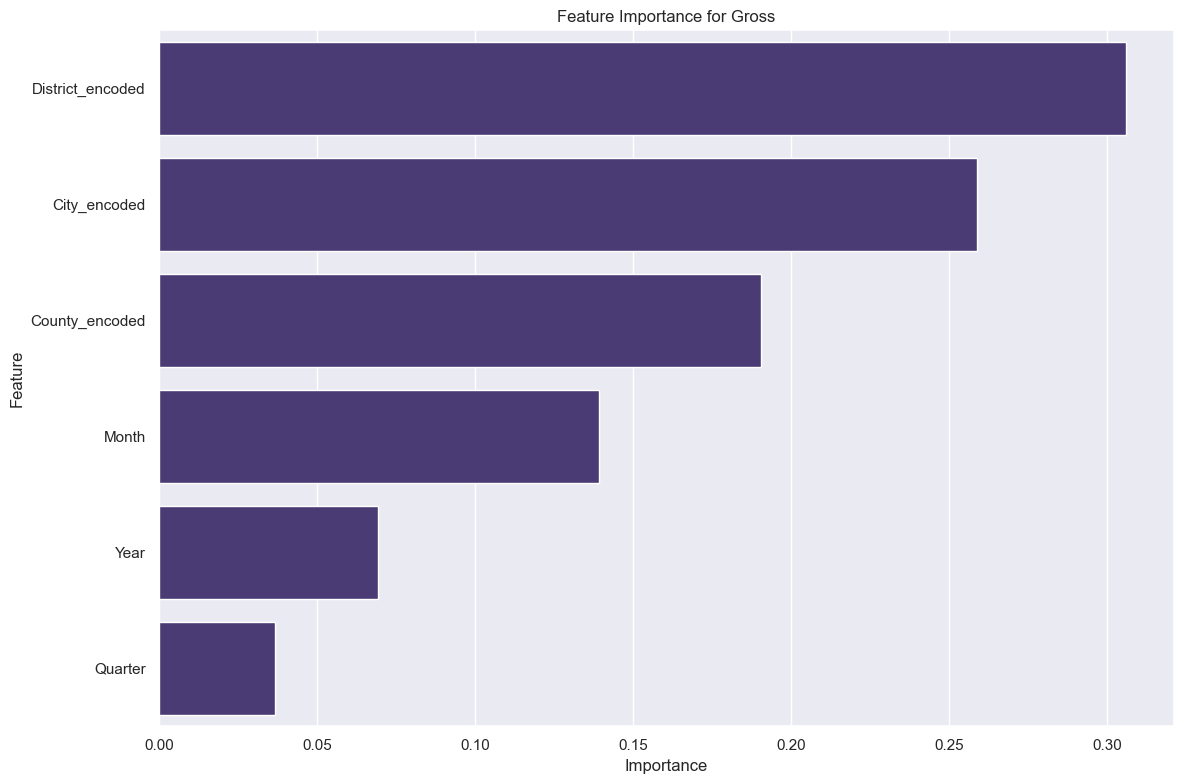

In [18]:
# Visualize feature importance for Gross
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_gross)
plt.title('Feature Importance for Gross')
plt.tight_layout()
plt.show()

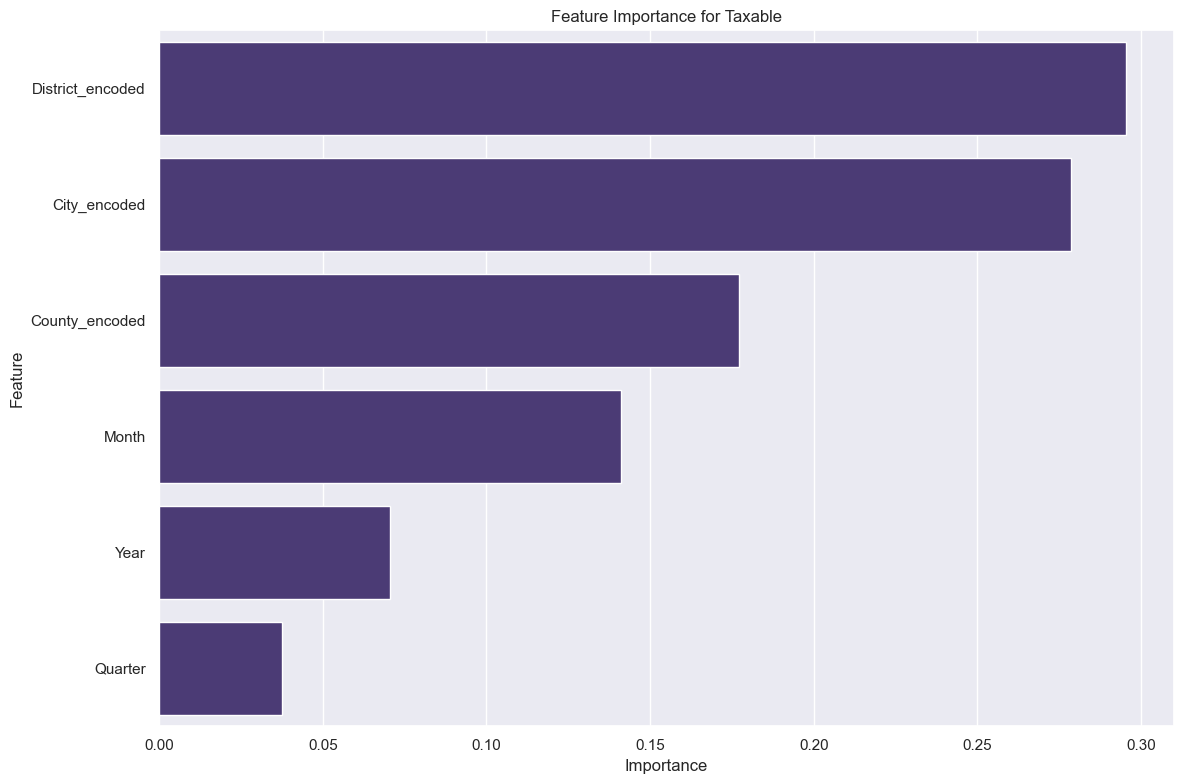

In [19]:
# Visualize feature importance for Taxable
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_taxable)
plt.title('Feature Importance for Taxable')
plt.tight_layout()
plt.show()

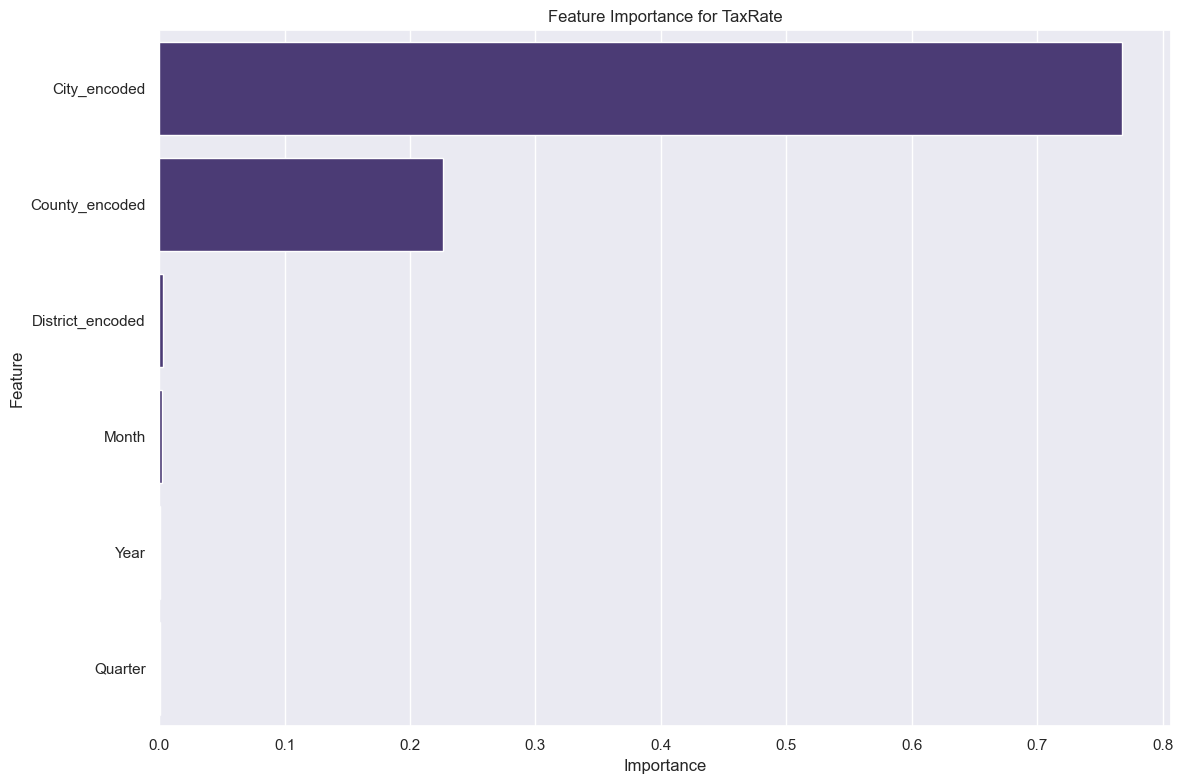

In [20]:
# Visualize feature importance for TaxRate
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_taxrate)
plt.title('Feature Importance for TaxRate')
plt.tight_layout()
plt.show()

## 5. Recommendations for New Features

Based on our analysis, we recommend creating the following new features:

1. Seasonal indicators based on Month
2. Regional aggregations of financial metrics
3. Growth rates (year-over-year, quarter-over-quarter)
4. Entity-specific metrics
5. Geographic clusters for spatial analysis